Notebook to:
* Read Embedded Element Patterns for AA0.5 stations.
* Generate expected AA0.5 visibility polarisations with various corrections.
* Display the results.

It requires local copies of the EEP files. These should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
# Imports

import logging
import sys

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import AltAz, SkyCoord, get_sun
from astropy import units
from astropy.time import Time
from ska_low_mccs_calibration.eep import (
    load_eeps,
    resample_eeps,
    station_beam_matrix,
    station_rotation_matrix,
)
from ska_low_mccs_calibration.sky_model import (
    solar_lsm,
)
from ska_low_mccs_calibration.utils import (
    read_yaml_config,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))







<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
# Get station info 

stations = ["s8-1.yaml", "s8-6.yaml", "s9-2.yaml", "s10-3.yaml"]

nstation = len(stations)
location = [""] * nstation
rotation = np.zeros(nstation, "float")

for stn_id, station in enumerate(stations):
    config = read_yaml_config(station)
    # config = [station_location, antenna_masks, baseline_ids, enu, pol, rotation]
    location[stn_id] = config[0]
    rotation[stn_id] = config[5]

nantenna = len(config[1])

read_yaml_station: extracting station s8-1
read_yaml_config: station rotation 251.300000 deg
read_yaml_station: extracting station s8-6
read_yaml_config: station rotation 193.600000 deg
read_yaml_station: extracting station s9-2
read_yaml_config: station rotation 56.100000 deg
read_yaml_station: extracting station s10-3
read_yaml_config: station rotation 44.200000 deg


In [3]:
# Get rotated EEPs for the four AA0.5 stations

# Observing frequency
channel_id = 140
channel_bw_MHz = 400.0 / 512.0
freq = channel_id * channel_bw_MHz

eep_file_path = "/Users/mit183/SKA/AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"
EEPs = load_eeps(freq, eep_file_path)

### Compare inter-station visibilities for different back-rotation options

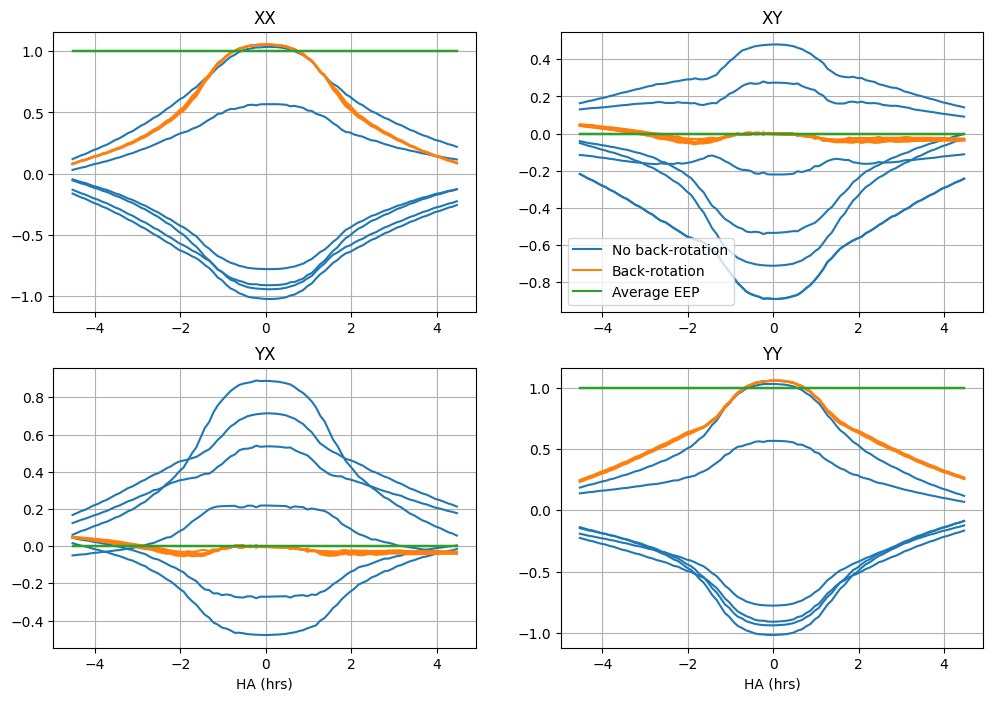

In [4]:
# Generate visibilities while tracking the sun at a range of hour angles

# Set the centre to midday in summer
time_mid = Time("2024-01-01T12:00:00", format="isot", scale="utc")
# Change to UTC
time_mid -= location[0].lon.degree / 15 * units.hour
hr_offsets = np.arange(-4.5, 4.5001, 0.1)

# Generate empty arrays for storing various cross correlations
Ntype = 3 # types of corrections to consider
Nprod = nstation * (nstation - 1) // 2 # number of cross products
Nsnap = len(hr_offsets) # number of snapshots to consider
label = [""] * Ntype
cross_prod = np.zeros((Nprod, Ntype, 2, 2, Nsnap), "complex")
ha_sun = np.zeros(len(hr_offsets))

for hr_id, hr in enumerate(hr_offsets):
    time = time_mid + hr * units.hour

    skypos = get_sun(time)
    skypos_altaz = skypos.transform_to(AltAz(obstime=time, location=location[0]))
    az_deg = skypos_altaz.az.degree
    el_deg = skypos_altaz.alt.degree
    lst_deg = time.sidereal_time("mean", location[0].lon).degree
    ha_sun[hr_id] = lst_deg - skypos.ra.degree

    # Get EEP matrices in the beam direction
    Jeep = np.zeros((nstation, nantenna, 2, 2), "complex")
    # Also save an "observed" version with some noise?
    Jobs = np.zeros((nstation, nantenna, 2, 2), "complex")
    sigma = 0.0
    for stn_id, station in enumerate(stations):
        Jeep[stn_id] = np.array(
            resample_eeps(EEPs, rotation[stn_id], az_deg, el_deg)
        ).T.reshape(nantenna, 2, 2)

        shape = Jeep[stn_id].shape
        noise = (
            np.random.normal(0.0, sigma, shape) + 1j * np.random.normal(0.0, sigma, shape)
        )
        Jobs[stn_id] = Jeep[stn_id].copy() + noise

    # Form expected response and cross products at beam centre
    #  - Assuming calibration and geometric phase factors have been corrected

    # ------------------------------------ #
    # Simple beamforming, no back-rotation #
    bftype = 0
    label[bftype] = "No back-rotation"
    # Form the expected beam response for each station
    beam = np.zeros((nstation, 2, 2), "complex")
    for stn_id, station in enumerate(stations):
        # Average over antennas
        beam[stn_id] = np.mean(Jobs[stn_id], axis=0)
    # Form expected cross products for each pair of stations
    prod_id = 0
    for stn1 in range(nstation - 1):
        for stn2 in range(stn1 + 1, nstation):
            cross_prod[prod_id, bftype, :, :, hr_id] = beam[stn1] @ beam[stn2].conj().T
            prod_id += 1

    # --------------------------------------------------------------- #
    # Calibration and back-rotation applied during simple beamforming #
    #  - back-rotation is constant and could be done after beamforming
    bftype = 1
    label[bftype] = "Back-rotation"
    # Form the expected beam response for each station
    beam = np.zeros((nstation, 2, 2), "complex")
    for stn_id, station in enumerate(stations):
        # Calibration applies the inverse of the rotation matrix
        #  - this is equivalent to inv(Jgain @ Jrotation)
        Jcal = station_rotation_matrix(rotation[stn_id], reverse=True)
        # Average over antennas
        beam[stn_id] = np.einsum("xp,spy->xy", Jcal, Jobs[stn_id]) / nantenna
    # Form expected cross products for each pair of stations
    prod_id = 0
    for stn1 in range(nstation - 1):
        for stn2 in range(stn1 + 1, nstation):
            cross_prod[prod_id, bftype, :, :, hr_id] = beam[stn1] @ beam[stn2].conj().T
            prod_id += 1

    # ---------------------------------------------------------------------- #
    # Calibration during simple beamforming, average EEPs applied afterwards #
    bftype = 2
    label[bftype] = "Average EEP"
    # Form the expected beam response for each station
    beam = np.zeros((nstation, 2, 2), "complex")
    for stn_id, station in enumerate(stations):
        # Average over antennas then correct for the average EEPs
        beam[stn_id] = np.linalg.inv(np.mean(Jeep[stn_id], axis=0)) @ np.mean(Jobs[stn_id], axis=0)
    # Form expected cross products for each pair of stations
    prod_id = 0
    for stn1 in range(nstation - 1):
        for stn2 in range(stn1 + 1, nstation):
            cross_prod[prod_id, bftype, :, :, hr_id] = beam[stn1] @ beam[stn2].conj().T
            prod_id += 1

x = (ha_sun - 360*(ha_sun>180)) / 15

types_to_plot = range(Ntype)

plt.figure(figsize=[12,8])
plt.subplot(221)
for bftype in types_to_plot:
    plt.plot(x, np.real(cross_prod[:, bftype, 0, 0]).T, f"C{bftype}")
plt.title("XX")
plt.grid()
plt.subplot(222)
for bftype in types_to_plot:
    plt.plot(x, np.real(cross_prod[0, bftype, 0, 1]).T, f"C{bftype}", label=label[bftype])
    plt.plot(x, np.real(cross_prod[:, bftype, 0, 1]).T, f"C{bftype}")
plt.title("XY")
plt.grid()
plt.legend()
plt.subplot(223)
for bftype in types_to_plot:
    plt.plot(x, np.real(cross_prod[:, bftype, 1, 0]).T, f"C{bftype}")
plt.title("YX")
plt.xlabel("HA (hrs)")
plt.grid()
plt.subplot(224)
for bftype in types_to_plot:
    plt.plot(x, np.real(cross_prod[:, bftype, 1, 1]).T, f"C{bftype}")
plt.title("YY")
plt.xlabel("HA (hrs)")
plt.grid()

### Compare alignment to IAU sky polarisations against an analytic short-dipole model

Note that the analytic short-dipole model is not expected to be a great match, these tests are simply to check the overall trends, which should be similar.

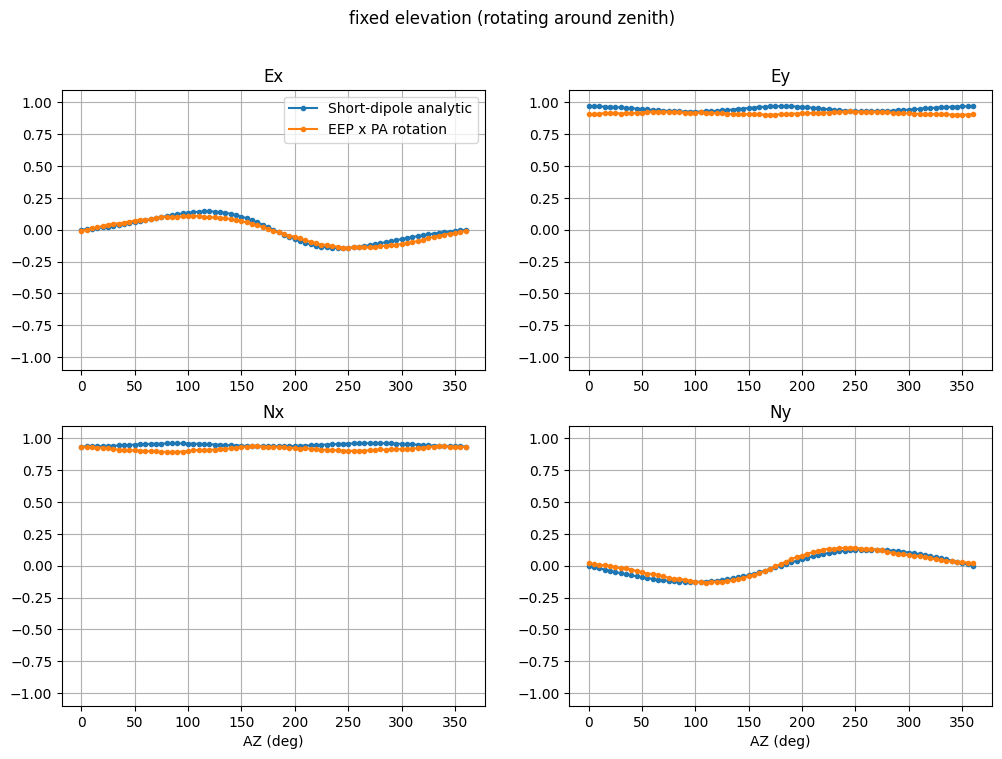

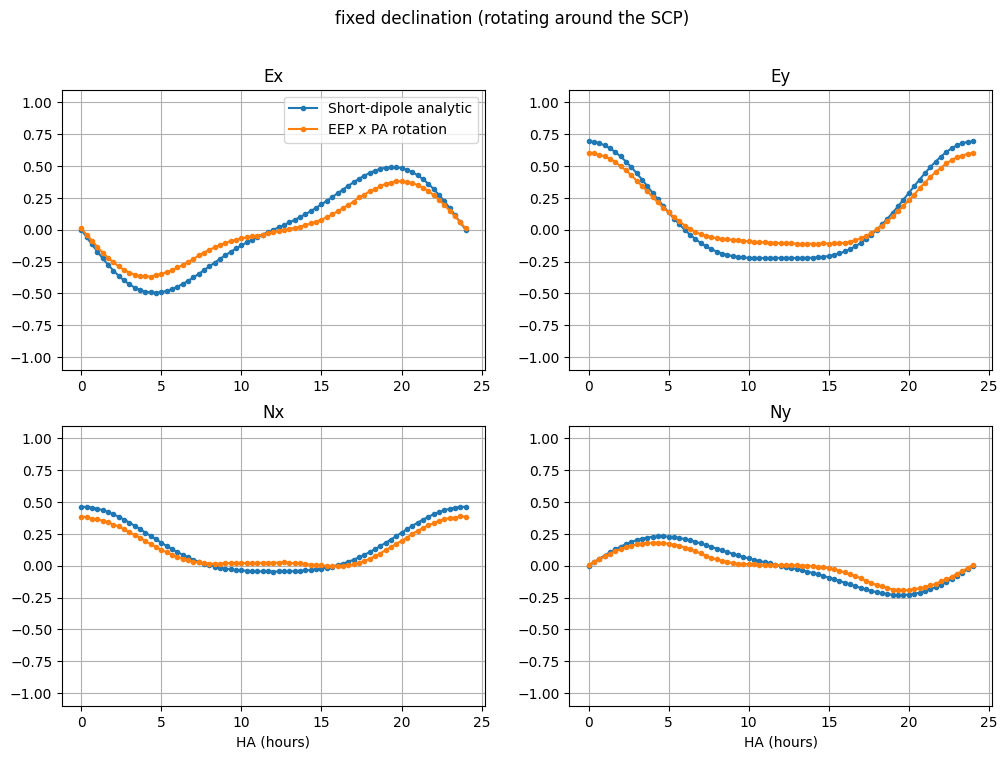

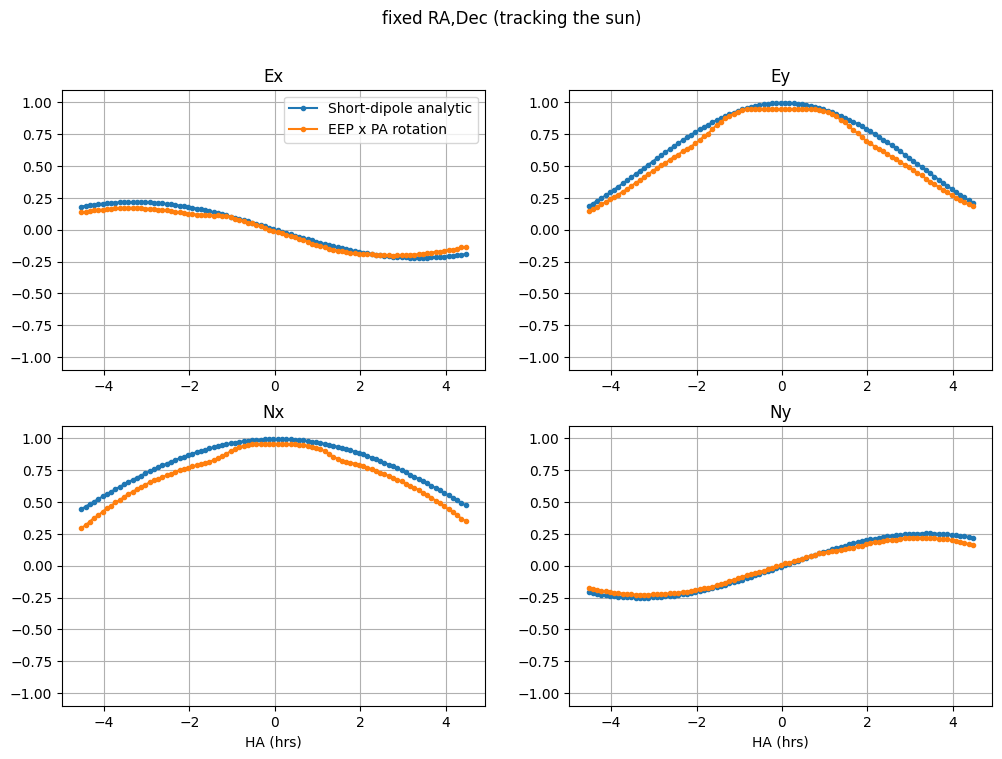

In [5]:
# EEPs have a pole at zenith while IAU coords have the south celestial pole
#  - compare results for a few different tracks:
#     - a circle about zenith
#     - a circle about the SCP
#     - the solar track from the previous example

def gen_rts(lat, ha, dec, skypos_altaz):
    # RTS matrix to convert from IAU x,y to NE receptors
    # i.e. transforms to [NS, EW] from [x, y]
    # Model is for short dipoles on a ground screen.
    #  - Not right for Low antennas, but the values below give a similar drop-off.

    za = (90 - skypos_altaz.alt.degree) * np.pi / 180
    dpl_hgt = 0.1 # empirecal value that gives a profile that is similar to the EEPs.
    ground_plane = np.sin(2.0*np.pi*dpl_hgt*np.cos(za)) /  np.sin(2.0*np.pi*dpl_hgt);

    return ground_plane * np.array(
        [
            # swap rows to change to [EW, NS] from [x, y] (EEP order)
            # [np.cos(lat) * np.cos(dec) + np.sin(lat) * np.sin(dec) * np.cos(ha), -np.sin(lat) * np.sin(ha)],
            # [np.sin(dec) * np.sin(ha), np.cos(ha)],
            [np.sin(dec) * np.sin(ha), np.cos(ha)],
            [np.cos(lat) * np.cos(dec) + np.sin(lat) * np.sin(dec) * np.cos(ha), -np.sin(lat) * np.sin(ha)],
        ]
    )

def do_plots(x, xlabel, title, Jrts, Jeep):

    fixscale = True

    fig = plt.figure(figsize=[12,8])
    fig.suptitle(title)

    ax = plt.subplot(221)
    plt.title("Ex")
    plt.plot(x, np.real(Jrts[:, 0, 0]), ".-", label="Short-dipole analytic")
    plt.plot(x, np.real(Jeep[:, 0, 0]), ".-", label="EEP x PA rotation")
    plt.legend()
    plt.grid()
    if fixscale: ax.set_ylim((-1.1, 1.1))

    ax = plt.subplot(222)
    plt.title("Ey")
    plt.plot(x, np.real(Jrts[:, 0, 1]), ".-")
    plt.plot(x, np.real(Jeep[:, 0, 1]), ".-")
    plt.grid()
    if fixscale: ax.set_ylim((-1.1, 1.1))

    ax = plt.subplot(223)
    plt.title("Nx")
    plt.xlabel(xlabel)
    plt.plot(x, np.real(Jrts[:, 1, 0]), ".-")
    plt.plot(x, np.real(Jeep[:, 1, 0]), ".-")
    plt.grid()
    if fixscale: ax.set_ylim((-1.1, 1.1))

    ax = plt.subplot(224)
    plt.xlabel(xlabel)
    plt.title("Ny")
    plt.plot(x, np.real(Jrts[:, 1, 1]), ".-")
    plt.plot(x, np.real(Jeep[:, 1, 1]), ".-")
    plt.grid()
    if fixscale: ax.set_ylim((-1.1, 1.1))

stn_id = 0

lat = location[stn_id].lat.degree * np.pi / 180

lst_deg = time.sidereal_time("mean", location[stn_id].lon).degree
lst = lst_deg * np.pi / 180

# rotate around zenith
az_input = np.arange(0, 361, 5)
Jrts = np.zeros((len(az_input), 2, 2), "complex")
Jeep = np.zeros((len(az_input), 2, 2), "complex")
for k, az_deg in enumerate(az_input):

    # get approx az/el
    az = az_deg * np.pi / 180
    el = 75 * np.pi / 180
    za = np.pi/2 - el
    ha  = np.arctan2(-np.sin(az)*np.sin(za), np.cos(lat)*np.cos(za) - np.sin(lat)*np.sin(za)*np.cos(az))
    dec = np.arcsin(                         np.sin(lat)*np.cos(za) + np.cos(lat)*np.sin(za)*np.cos(az))

    # reset everything more carefully
    ha_deg = ha * 180 / np.pi % 360
    ra_deg = lst_deg - ha_deg
    dec_deg = dec * 180 / np.pi
    skypos_radec = SkyCoord(ra_deg, dec_deg, unit="deg")
    skypos_altaz = skypos_radec.transform_to(AltAz(obstime=time, location=location[stn_id]))

    ha = ha_deg * np.pi / 180
    dec = dec_deg * np.pi / 180
    Jrts[k] = gen_rts(lat, ha, dec, skypos_altaz)
    Jeep[k] = station_beam_matrix(
        EEPs, 0.0, location[stn_id], time, ra_deg, dec_deg, pa_correction=True
    )

do_plots(az_input, "AZ (deg)", "fixed elevation (rotating around zenith)", Jrts, Jeep)

# rotate around the south celestial pole
ha_input = np.arange(0, 361, 5)
Jrts = np.zeros((len(ha_input), 2, 2), "complex")
Jeep = np.zeros((len(ha_input), 2, 2), "complex")
for k, ha_deg in enumerate(ha_input):
    ra_deg = lst_deg - ha_deg

    skypos_radec = SkyCoord(ra_deg, -75, unit="deg")
    skypos_altaz = skypos_radec.transform_to(AltAz(obstime=time, location=location[stn_id]))

    ra = skypos_radec.ra.degree * np.pi / 180
    ha = lst - ra
    dec = skypos_radec.dec.degree * np.pi / 180

    Jrts[k] = gen_rts(lat, ha, dec, skypos_altaz)
    Jeep[k] = station_beam_matrix(
        EEPs, 0.0, location[stn_id], time, skypos_radec.ra.degree, skypos_radec.dec.degree, pa_correction=True
    )

do_plots(ha_input / 15, "HA (hours)", "fixed declination (rotating around the SCP)", Jrts, Jeep)

# track the sun
Jrts = np.zeros((len(hr_offsets), 2, 2), "complex")
Jeep = np.zeros((len(hr_offsets), 2, 2), "complex")
for hr_id, hr in enumerate(hr_offsets):
    time = time_mid + hr * units.hour

    skypos = get_sun(time)
    skypos_altaz = skypos.transform_to(AltAz(obstime=time, location=location[stn_id]))
    az_deg = skypos_altaz.az.degree
    el_deg = skypos_altaz.alt.degree
    lst_deg = time.sidereal_time("mean", location[stn_id].lon).degree

    az = az_deg * np.pi / 180
    el = el_deg * np.pi / 180
    za = np.pi/2 - el
    ha  = np.arctan2(-np.sin(az)*np.sin(za), np.cos(lat)*np.cos(za) - np.sin(lat)*np.sin(za)*np.cos(az))
    dec = np.arcsin(                         np.sin(lat)*np.cos(za) + np.cos(lat)*np.sin(za)*np.cos(az))

    # reset everything more carefully
    ha_deg = ha * 180 / np.pi % 360
    ra_deg = lst_deg - ha_deg
    dec_deg = dec * 180 / np.pi
    skypos_radec = SkyCoord(ra_deg, dec_deg, unit="deg")
    skypos_altaz = skypos_radec.transform_to(AltAz(obstime=time, location=location[stn_id]))

    ha = ha_deg * np.pi / 180
    dec = dec_deg * np.pi / 180
    Jrts[hr_id] = gen_rts(lat, ha, dec, skypos_altaz)
    Jeep[hr_id] = station_beam_matrix(
        EEPs, 0.0, location[stn_id], time, ra_deg, dec_deg, pa_correction=True
    )

do_plots((ha_sun - 360*(ha_sun>180))/15, "HA (hrs)", "fixed RA,Dec (tracking the sun)", Jrts, Jeep)

plt.show()